# [官方教學](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) [GitHub](https://github.com/pytorch/vision/tree/main/references/detection)

---

# [PennFudan Dataset](https://www.cis.upenn.edu/~jshi/ped_html/)

```
PennFudanPed
├─ Annotation
|  ├─ FudanPed00001.txt
|  ├─ FudanPed00002.txt
|  ...
├─ PedMasks
|  ├─ FudanPed00001_mask.png
|  ├─ FudanPed00002_mask.png
|  ...
├─ PNGImages
|  ├─ FudanPed00001.png
|  ├─ FudanPed00002.png
|  ...
├─ added-object-list.txt
└─ readme.txt
```

In [1]:
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class PennFudanDataset(Dataset):
    """PennFudan Dataset.

    Attributes:
        image_names (list): Image names.
        images (list): Images.
        masks (list): Segmentation masks for each objects.
        boxes (list): Bounding boxes for each objects in [x_min, y_min, x_max, y_max] format.
        labels (list): Labels for each objects. There is only one class: pedestrian.
    """

    def __init__(self, path, transform=transforms.ToTensor()):
        """
        Args:
            path (str): Path of PennFudan dataset.
            transform (torchvision.transforms): Transform for image.
        """

        # 取得所有 image 和 mask 的路徑

        image_names = os.listdir(os.path.join(path, 'PNGImages'))
        image_paths = [os.path.join(path, 'PNGImages', name) for name in image_names]
        mask_names = [f'{os.path.splitext(name)[0]}_mask.png' for name in image_names]
        mask_paths = [os.path.join(path, 'PedMasks', name) for name in mask_names]
        self.image_names = [os.path.splitext(name)[0] for name in image_names]

        # 讀取資料

        self.images = []
        self.masks = []
        self.boxes = []
        self.labels = []
        for image_path, mask_path in zip(image_paths, mask_paths):

            # 讀取 image

            image = Image.open(image_path).convert('RGB')
            image = transform(image)
            self.images.append(image)

            # 讀取 mask

            mask = np.array(Image.open(mask_path))
            object_ids = np.unique(mask) # np.unique(array)：找出陣列中元素的種類
            object_ids = object_ids[1:] # 0 為背景，去掉 0
            masks = mask == object_ids[:, None, None] # 將 mask 轉成一個物件一張圖
            self.masks.append(torch.tensor(masks, dtype=torch.uint8))

            # 計算 bounding boxes

            boxes = []
            for mask in masks:
                y, x = np.where(mask) # np.where(array)：回傳陣列中元素為 True 的坐標
                boxes.append([np.min(x), np.min(y), np.max(x), np.max(y)])
            self.boxes.append(torch.tensor(boxes, dtype=torch.float32))

            # 生成 labels

            self.labels.append(torch.ones(len(object_ids), dtype=torch.int64)) # 此資料集的物件類別只有一種

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Input index.

        Returns:
            image (torch.Tensor): An image.
            target (dict): {'masks' (torch.Tensor): Segmentation masks for each objects,
                            'boxes' (torch.Tensor): Bounding boxes for each objects,
                            'labels' (torch.Tensor): Labels for each objects}.

        Shape:
            image: (C, H, W).
            target: {'masks': (N, H, W),
                     'boxes': (N, 4),
                     'labels': (N)}.
        """
        image = self.images[idx]
        target = {'masks': self.masks[idx], 'boxes': self.boxes[idx], 'labels': self.labels[idx]}
        return image, target

    def get_num_classes(self):
        return 2

In [2]:
def collate_fn(batch):
    """Customized collate_fn for dataloader.

    Args:
        batch (list): [dataset[0], dataset[1], ...].
    """
    return tuple(zip(*batch)) # zip(*batch) = zip(dataset[0], dataset[1], ...)

In [3]:
from torch.utils.data import DataLoader

path = r'C:\Datasets\PennFudanPed'

In [4]:
dataset = PennFudanDataset(path)
print('dataset length =', len(dataset))

dataset length = 170


In [5]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
dataiter = iter(dataloader)
images, targets = dataiter.__next__()
print('images length =', len(images))
print('targets length =', len(targets))

images length = 2
targets length = 2


In [6]:
print('image:', type(images[0]), images[0].dtype, images[0].shape)
print('boxes:', type(targets[0]['boxes']), targets[0]['boxes'].dtype, targets[0]['boxes'].shape)
print('labels:', type(targets[0]['labels']), targets[0]['labels'].dtype, targets[0]['labels'].shape)
print('masks:', type(targets[0]['masks']), targets[0]['masks'].dtype, targets[0]['masks'].shape)

image: <class 'torch.Tensor'> torch.float32 torch.Size([3, 536, 559])
boxes: <class 'torch.Tensor'> torch.float32 torch.Size([2, 4])
labels: <class 'torch.Tensor'> torch.int64 torch.Size([2])
masks: <class 'torch.Tensor'> torch.uint8 torch.Size([2, 536, 559])


# [Faster R-CNN](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)

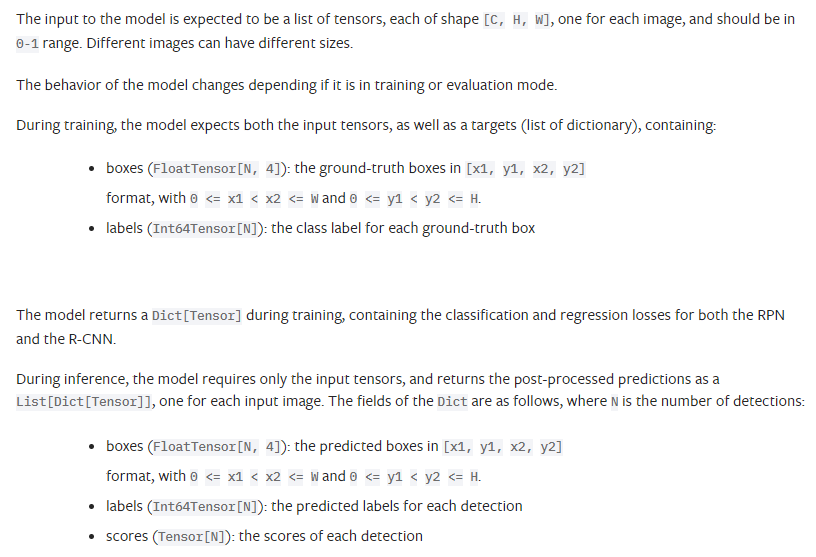

In [7]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [8]:
fasterrcnn = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
fasterrcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [9]:
in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, dataset.get_num_classes())
fasterrcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [10]:
output = fasterrcnn(images, targets)
output

{'loss_classifier': tensor(0.6344, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1808, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0452, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0074, grad_fn=<DivBackward0>)}

In [11]:
fasterrcnn.eval()

inputs = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
outputs = fasterrcnn(inputs)
outputs

[{'boxes': tensor([[0.0000e+00, 0.0000e+00, 3.1994e+02, 3.4809e+01],
          [2.6071e+02, 0.0000e+00, 3.5268e+02, 1.1868e+00],
          [3.0350e+02, 1.3878e+02, 3.0922e+02, 1.4320e+02],
          [3.2538e+02, 7.7957e-03, 3.7840e+02, 1.5487e+00],
          [1.5450e+02, 1.5055e-01, 2.4738e+02, 1.5349e+00],
          [6.2020e+01, 0.0000e+00, 4.0000e+02, 2.2936e+01],
          [1.8483e+02, 0.0000e+00, 2.6956e+02, 1.0181e+00],
          [2.3554e+02, 0.0000e+00, 3.1639e+02, 1.1850e+00],
          [0.0000e+00, 0.0000e+00, 2.3647e+02, 2.1961e+01],
          [0.0000e+00, 0.0000e+00, 5.3919e+01, 1.5211e+00],
          [0.0000e+00, 0.0000e+00, 3.4425e+02, 6.7038e+01],
          [1.5507e+02, 0.0000e+00, 3.9931e+02, 8.5390e+00],
          [0.0000e+00, 2.0758e-01, 2.6522e+02, 9.0917e+00],
          [2.9572e+02, 1.3998e+02, 3.0106e+02, 1.4433e+02],
          [2.4653e+02, 0.0000e+00, 3.9975e+02, 1.5125e+01],
          [2.4713e+02, 3.0580e-01, 3.1874e+02, 1.6600e+00],
          [2.1087e+02, 9.3326e-

In [12]:
print('outputs length =', len(outputs))

outputs length = 2


In [13]:
print('boxes:', type(outputs[0]['boxes']), outputs[0]['boxes'].dtype, outputs[0]['boxes'].shape)
print('labels:', type(outputs[0]['labels']), outputs[0]['labels'].dtype, outputs[0]['labels'].shape)
print('scores:', type(outputs[0]['scores']), outputs[0]['scores'].dtype, outputs[0]['scores'].shape)

boxes: <class 'torch.Tensor'> torch.float32 torch.Size([100, 4])
labels: <class 'torch.Tensor'> torch.int64 torch.Size([100])
scores: <class 'torch.Tensor'> torch.float32 torch.Size([100])


# Training

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def print_loss(iteration, total_iterations, loss, loss_name='loss'):
    """Clean the line and print the loss.

    Args:
        iteration (int): This iteration.
        total_iterations (int): Total iterations.
        loss (number): Loss value.
        loss_name (str): Loss name.
    """
    string = f'{iteration}/{total_iterations} - {loss_name}: {loss:.4f}'
    space = '                              '
    print(f'\r{space}', end='\r')
    if iteration != total_iterations:
        print(string, end='', flush=True)
    else:
        print(string)

def output_loss(output_name, train_loss_history, test_loss_history,
                steps_per_epoch, epochs, loss_name='loss'):
    """Output loss files and plots.

    Args:
        output_name (str): Output name.
        train_loss_history (numpy.ndarray): Training loss history.
        test_loss_history (numpy.ndarray): Testing loss history.
        steps_per_epoch (int): Steps per epoch.
        epochs (int): Training epochs.
        loss_name (str): Loss name.
    """
    np.savetxt(f'plots/{output_name}.{loss_name}.train.txt', train_loss_history)
    np.savetxt(f'plots/{output_name}.{loss_name}.test.txt', test_loss_history)
    plt.plot(train_loss_history)
    plt.plot(np.linspace(steps_per_epoch, steps_per_epoch*epochs, num=epochs), test_loss_history)
    plt.legend(['training loss', 'testing loss'])
    plt.xlabel('iteration')
    plt.ylabel(loss_name)
    plt.savefig(f'plots/{output_name}.{loss_name}.png')
    plt.close()

In [15]:
import os
import numpy as np
import time
import datetime
import torch
from torch import optim
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

output_name = 'demo'
path = r'C:\Datasets\PennFudanPed'
batch_size = 4
num_workers = 0
pin_memory = True
pretrained_weights = 'DEFAULT'
lr = 0.00001
epochs = 10
checkpoint_epochs = 10
device = torch.device('cuda')
transform = transforms.ToTensor()

In [16]:
t_start = time.time()

# 建立資料夾

if not os.path.isdir('checkpoints'):
    os.mkdir('checkpoints')
if not os.path.isdir('plots'):
    os.mkdir('plots')

# 載入資料集

dataset = PennFudanDataset(path, transform=transform)
indices = torch.randperm(len(dataset)).tolist() # torch.randperm(n)：隨機排列整數 0 到 n-1
trainset = Subset(dataset, indices[:-50])
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, collate_fn=collate_fn,
                         pin_memory=pin_memory, drop_last=True)
testset = Subset(dataset, indices[-50:])
testloader = DataLoader(testset, batch_size=1, shuffle=False,
                        num_workers=num_workers, collate_fn=collate_fn,
                        pin_memory=pin_memory)

# 載入模型

fasterrcnn = fasterrcnn_resnet50_fpn_v2(weights=pretrained_weights)
in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, dataset.get_num_classes())
fasterrcnn.to(device)

# 訓練設置

optimizer = optim.Adam(fasterrcnn.parameters(), lr=lr)

In [17]:
# 開始訓練

train_loss_history = []
test_loss_history = []
print(f'Start training {output_name}...')
for i in range(epochs):
    print(f'Epoch {i+1}/{epochs}')

    # 訓練

    for j, (images, targets) in enumerate(trainloader):
        images = [image.to(device) for image in images]
        targets =  [{key: value.to(device) for key, value in target.items()} for target in targets]

        optimizer.zero_grad()
        loss_dict = fasterrcnn(images, targets)
        loss = sum(loss_dict.values())
        loss.backward()
        optimizer.step()

        train_loss_history.append([value.item() for value in loss_dict.values()])
        print_loss(j+1, len(trainloader), loss)

    # 計算測試資料集的 loss

    losses = []
    with torch.no_grad():
        for image, target in testloader:
            image = [image[0].to(device)]
            target =  [{key: value.to(device) for key, value in target[0].items()}]
            loss_dict = fasterrcnn(image, target)
            losses.append([value.item() for value in loss_dict.values()])
    test_loss_history.append(np.mean(losses, axis=0))
    print(f'Testing loss: {np.sum(test_loss_history[-1]):.4f}')

    # 儲存檢查點

    if (i+1)%checkpoint_epochs == 0:
        torch.save({
            'model': fasterrcnn.state_dict(),
            'optimizer': optimizer.state_dict()
        }, f'checkpoints/{output_name}.pt-{i+1}')

# 輸出 loss 檔案

output_loss(output_name, np.sum(train_loss_history, axis=1),
            np.sum(test_loss_history, axis=1), len(trainloader), epochs)
for i, loss_name in enumerate(['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']):
    output_loss(output_name, np.array(train_loss_history)[:, i],
                np.array(test_loss_history)[:, i], len(trainloader), epochs, loss_name=loss_name)

Start training demo...
Epoch 1/10
30/30 - loss: 0.2965          
Testing loss: 0.3332
Epoch 2/10
30/30 - loss: 0.1502          
Testing loss: 0.2175
Epoch 3/10
30/30 - loss: 0.1483          
Testing loss: 0.1479
Epoch 4/10
30/30 - loss: 0.0744          
Testing loss: 0.1318
Epoch 5/10
30/30 - loss: 0.0593          
Testing loss: 0.1202
Epoch 6/10
30/30 - loss: 0.0421          
Testing loss: 0.1130
Epoch 7/10
30/30 - loss: 0.0473          
Testing loss: 0.1099
Epoch 8/10
30/30 - loss: 0.0283          
Testing loss: 0.1108
Epoch 9/10
30/30 - loss: 0.0371          
Testing loss: 0.1079
Epoch 10/10
30/30 - loss: 0.0214          
Testing loss: 0.1035


In [18]:
# 紀錄時間

t_end = time.time()
t = t_end - t_start
with open(f'checkpoints/{output_name}.time.txt', 'w') as f:
    f.write(str(datetime.timedelta(seconds=t)))

Text(0, 0.5, 'loss')

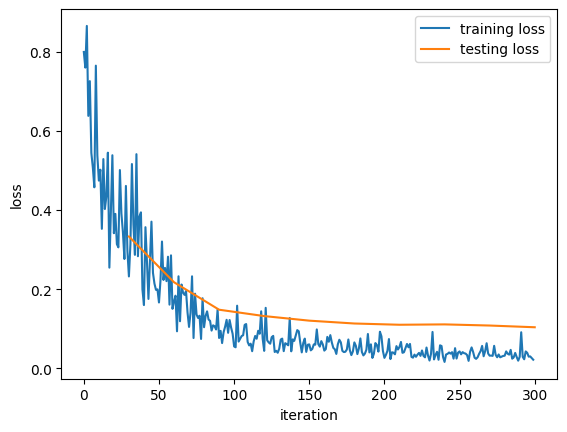

In [19]:
import matplotlib.pyplot as plt

plt.plot(np.sum(train_loss_history, axis=1))
plt.plot(np.linspace(len(trainloader), len(trainloader)*epochs, num=epochs),
         np.sum(test_loss_history, axis=1))
plt.legend(['training loss', 'testing loss'])
plt.xlabel('iteration')
plt.ylabel('loss')

# Testing

In [20]:
from PIL import Image
from torchvision.utils import draw_bounding_boxes

def output_pred_image(image_path, image, output_dict, classes, colors, threshold=0.6):
    """Output an image of the detection result.

    Args:
        image_path (str): Path of output image.
        image (torch.Tensor): Input image in (C, H ,W) shape.
        output_dict (dict): Model output.
        classes (list): Class names.
        color (list): Bounding box colors.
        threshold (float): Score threshold.
    """
    for box, label, score in zip(*output_dict.values()):
        if score > threshold:
            image = draw_bounding_boxes(image, box.unsqueeze(0), labels=[classes[label-1]], colors=[colors[label-1]])
    Image.fromarray(image.permute(1, 2, 0).cpu().numpy()).save(image_path)

In [21]:
import json
from torchmetrics.detection.mean_ap import MeanAveragePrecision

classes = ['pedestrian']
colors = ['white']
score_threshold = 0.6

In [22]:
# 建立資料夾

if not os.path.isdir('results'):
    os.mkdir('results')
dir_path = os.path.join('results', output_name)
if not os.path.isdir(dir_path):
    os.mkdir(dir_path)

# 開始測試

fasterrcnn.eval()
image_names = np.array(dataset.image_names)[indices[-50:]]
preds = []
targets = []
total_inference_time = 0
count_inference_time = 0
print(f'Start testing {output_name}...')
with torch.no_grad():
    for (image, target), image_name in zip(testloader, image_names):

        # 測試

        image = [image[0].to(device)]
        target =  [{key: value.to(device) for key, value in target[0].items()}]

        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        output = fasterrcnn(image)
        end_event.record()
        torch.cuda.synchronize()                             # 等待 CUDA 上所有程序完成
        inference_time = start_event.elapsed_time(end_event) # 計算 inference time
        total_inference_time += inference_time
        count_inference_time += 1

        preds = preds + output
        targets = targets + target
        
        # 輸出偵測結果影像

        image_path = os.path.join(dir_path, f'{image_name}.pred.jpg')
        image = (image[0]*255).to(torch.uint8) # [0, 1] → [0, 255], float32 → uint8
        output_pred_image(image_path, image, output[0], classes, colors, threshold=score_threshold)

# 計算 mAPs

metric = MeanAveragePrecision()
metric.update(preds, targets)
results = metric.compute()

# 輸出檔案

preds = [{key: value.tolist() for key, value in pred.items()} for pred in preds]
preds = [{'image_name': image_name, **pred} for pred, image_name in zip(preds, image_names)]
preds_json_path = os.path.join(dir_path, 'preds.json')
with open(preds_json_path, 'w') as f:
    json.dump(preds, f)
results = {key: value.item() for key, value in results.items()}
results_json_path = os.path.join(dir_path, 'results.json')
with open(results_json_path, 'w') as f:
    json.dump(results, f)

print(f'mAP = {results["map"]:.4f}')
print(f'Inference time = {total_inference_time/count_inference_time:.4f} ms')

Start testing demo...
mAP = 0.8085
Inference time = 40.7940 ms


In [23]:
results

{'map': 0.8085492253303528,
 'map_50': 0.9763233661651611,
 'map_75': 0.9208699464797974,
 'map_small': 0.4757425785064697,
 'map_medium': 0.7765676975250244,
 'map_large': 0.822648823261261,
 'mar_1': 0.36480000615119934,
 'mar_10': 0.8479999303817749,
 'mar_100': 0.8479999303817749,
 'mar_small': 0.533333420753479,
 'mar_medium': 0.785714328289032,
 'mar_large': 0.8600000143051147,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0}

### [COCO Metrics](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)
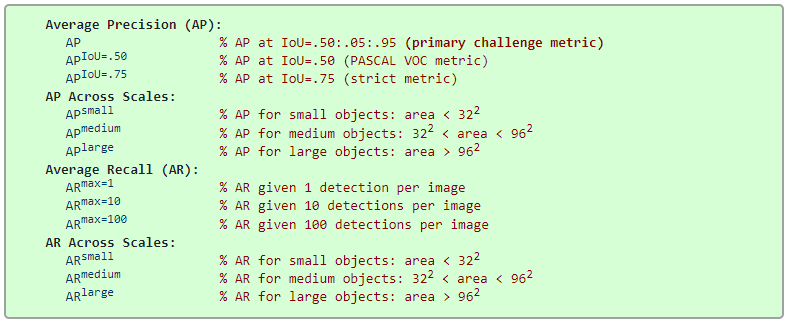

# Prediction

In [24]:
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes


image_path = r'pedestrian.jpg' # 圖片來源：https://callsam.com/blog/michigan-pedestrian-crosswalk-laws/

In [25]:
# 預測

image = Image.open(image_path).convert('RGB')
fasterrcnn.eval()
with torch.no_grad():
    input = transform(image).to(device)
    output = fasterrcnn([input])

# 繪製偵測框

image = F.pil_to_tensor(image)
for box, label, score in zip(*output[0].values()):
    if score > score_threshold:
        image = draw_bounding_boxes(image, box.unsqueeze(0), labels=[classes[label-1]], colors=[colors[label-1]])

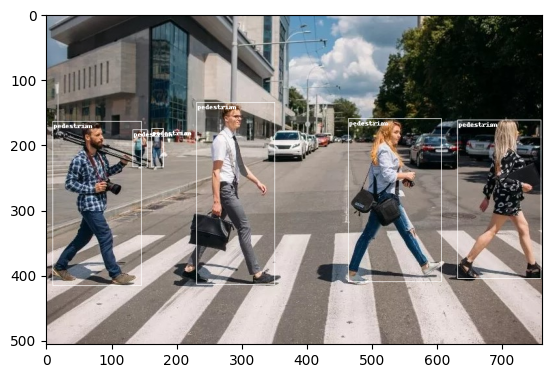

In [26]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))